---

CARGA DE LIBERERÍAS

----

In [85]:
#!pip install kmodes

In [86]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
from matplotlib import style

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
#Este archivo ya parte con:
# - nombres de las columnas cambiados
# - imputación de valores nulos con mediana y moda
# - formato de los datos correcto
# - transformaciones box-cox/yeo-johnson
#------------------------------------------------------

df = pd.read_csv('/content/drive/MyDrive/df_filtrado_preprocesado_2.csv')

---
ELIMINACIÓN VARIABLES CON MENOS PODER PREDICTIVO SOBRE LABEL

---

In [88]:
#Variables eliminadas segun EDA y LASSO

#top 5 segun rf -> thalach, oldpeak, age, chol, trestpbs
#capturan 67-70% del modelo en rf

display(df.shape)
df = df.drop(columns=['electro_en_descanso','azucar'],axis = 1)
display(df.shape)

(732, 14)

(732, 12)

In [89]:
df.head()

,edad,sexo,tipo_dolor_pecho,tension_en_descanso,colesterol,latidos_por_minuto,dolor_pecho_con_ejercicio,cambio_linea_corazon_ejercicio,forma_linea_corazon_ejercicio,num_venas_grandes,estado_corazon_thal,label
0,51,1,1,125.0,72.941231,125.0,1.0,1.972631,1.0,1.0,3.0,0
1,54,1,3,120.0,79.095790,150.0,1.0,2.021096,2.0,0.0,7.0,2
2,63,1,4,140.0,0.000000,149.0,0.0,2.254714,1.0,0.0,7.0,2
3,52,0,2,140.0,75.525658,140.0,0.0,1.213685,2.0,0.0,7.0,0
4,55,1,4,140.0,73.978565,111.0,1.0,3.646105,3.0,0.0,7.0,3


---
### CLUSTER K-MEANS

---

---
Normalizar las variables continuas

---

In [90]:
continuous_vars = ["edad",
    "tension_en_descanso",
    "colesterol",
    "latidos_por_minuto",
    "cambio_linea_corazon_ejercicio"]

# Creamos el subset
X_cont = df[continuous_vars].copy()

# StandardScaler media 0 y varianza 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cont)

# Convertimos a DF
X_scaled_df = pd.DataFrame(X_scaled, columns=continuous_vars)

---

CÁLCULO DE K ÓPTIMO Y SILOUTHE SCORE PARA CADA K

---

Calculando métricas para distintos K...


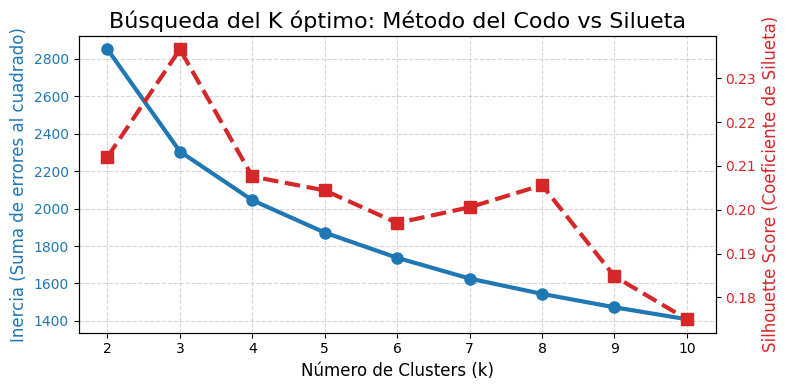


 Según el Silhouette Score, la mejor separación matemática se logra con k = 3 (Score: 0.237)


In [91]:
# 3. Bucle para calcular Inercia (Codo) y Silueta
inertia = []
silhouette_avgs = []
k_range = range(2, 11)  # Probamos de 2 a 10 clusters

print("Calculando métricas para distintos K...")

for k in k_range:
    # n_init=10 ejecuta el algoritmo 10 veces con distintas semillas para asegurar estabilidad
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    # Guardamos inercia (Suma de distancias al cuadrado intra-cluster)
    inertia.append(kmeans.inertia_)

    # Guardamos silueta (Que tan bien separados están los clusters)
    cluster_labels = kmeans.labels_
    silhouette_avgs.append(silhouette_score(X_scaled, cluster_labels))

# 4. Visualización Gráfica (Codo y Silueta)
fig, ax1 = plt.subplots(figsize=(8, 4))

# Eje Y izquierdo: Inercia (Codo)
color = 'tab:blue'
ax1.set_xlabel('Número de Clusters (k)', fontsize=12)
ax1.set_ylabel('Inercia (Suma de errores al cuadrado)', color=color, fontsize=12)
ax1.plot(k_range, inertia, 'o-', color=color, linewidth=3, markersize=8, label='Inercia (Codo)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Eje Y derecho: Silueta
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score (Coeficiente de Silueta)', color=color, fontsize=12)
ax2.plot(k_range, silhouette_avgs, 's--', color=color, linewidth=3, markersize=8, label='Silueta')
ax2.tick_params(axis='y', labelcolor=color)

# Título y anotaciones
plt.title('Búsqueda del K óptimo: Método del Codo vs Silueta', fontsize=16)
fig.tight_layout()
plt.show()

# 5. Imprimir el mejor K según Silueta
best_k = k_range[np.argmax(silhouette_avgs)]
best_score = max(silhouette_avgs)
print(f"\n Según el Silhouette Score, la mejor separación matemática se logra con k = {best_k} (Score: {best_score:.3f})")

**1. Ausencia de Fronteras Naturales (Inercia)**
* **Observación:** La curva de inercia (línea azul) es suave y continua, sin presentar un "codo" o punto de inflexión.
* **Significado:** Los datos no forman grupos aislados. La condición de los pacientes se presenta como un **espectro continuo** en lugar de categorías discretas. No hay una separación entre grupos al tener un silhouette cercano a 0, por lo que los grupos formados no son compactos entre si

**2. Conflicto Dimensional (K=3 vs K=5)**
* **Análisis Matemático:** Las variables continuas sugieren una agrupación óptima de **3 clusters** (interpretables como Riesgo Bajo, Medio y Alto).
* **Incompatibilidad:** Esto genera un conflicto estructural con el **Target original de 5 clases**. Las variables actuales no tienen la resolución suficiente para justificar una división en 5 grupos; forzar esta división puede introducir ruido en el modelo.

---

### CLUSTER K-PROTOTYPES

---


In [92]:
categorical_vars = ["sexo",
    "tipo_dolor_pecho",
    "dolor_pecho_con_ejercicio",
    "forma_linea_corazon_ejercicio",
    "estado_corazon_thal",
    "num_venas_grandes"]

X_cat = df[categorical_vars].copy()

# Reseteamos índices para evitar problemas al concatenar
X_scaled_df = pd.DataFrame(X_scaled, columns=continuous_vars).reset_index(drop=True)
X_cat = X_cat.reset_index(drop=True)

# Unimos todo en un solo DataFrame Híbrido
X_hybrid = pd.concat([X_scaled_df, X_cat], axis=1)

In [93]:
n_cont = len(continuous_vars)
n_cat = len(categorical_vars)
# Los índices de las categóricas son desde n_cont hasta el final
categorical_indices = list(range(n_cont, n_cont + n_cat))

print(f"Indices de columnas categóricas: {categorical_indices}")
print(f"Total columnas: {X_hybrid.shape[1]}")

Indices de columnas categóricas: [5, 6, 7, 8, 9, 10]
Total columnas: 11


K=2 completado. Costo: 3466.18
K=3 completado. Costo: 2919.33
K=4 completado. Costo: 2634.68
K=5 completado. Costo: 2460.57
K=6 completado. Costo: 2316.62
K=7 completado. Costo: 2200.16
K=8 completado. Costo: 2125.83
K=9 completado. Costo: 2042.61


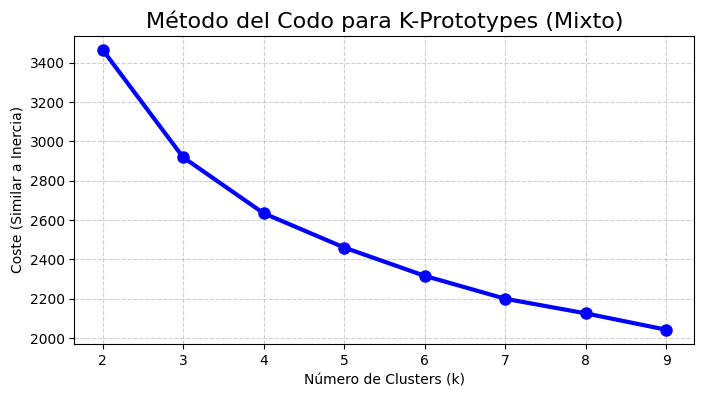

In [95]:
costs = []
k_range = range(2, 10)

for k in k_range:
    try:
        # init='Cao' es un método de inicialización optimizado para datos mixtos
        kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42, n_jobs=-1)
        clusters = kproto.fit_predict(X_hybrid, categorical=categorical_indices)
        costs.append(kproto.cost_)
        print(f"K={k} completado. Costo: {kproto.cost_:.2f}")
    except Exception as e:
        print(f"Error en K={k}: {e}")

# 4. Gráfico del Codo para K-Prototypes
plt.figure(figsize=(8, 4))
plt.plot(k_range, costs, 'bo-', linewidth=3, markersize=8)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coste (Similar a Inercia)')
plt.title('Método del Codo para K-Prototypes (Mixto)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Inviabilidad del Modelo

Al agregar variables categóricas (K-Prototypes), la estructura no mejoró. Esto prueba que la falta de separación es intrínseca a los datos, no culpa del algoritmo elegido.

### 1. El Problema de la Curva


* **Sin "Codo":** La línea de costo desciende suavemente (lineal). No hay un punto de inflexión donde la ganancia de información se estabilice.
* **Corte Arbitrario:** Pasar de $k=4$ a $k=5$ reduce el error casi igual que de $5$ a $6$. El algoritmo no agrupa, solo "recorta" datos continuos.

### 2. Fallo de Estructura (K-Prototypes)

* **Hipótesis Fallida:** Las variables categóricas (*Dolor, Sexo, Venas*) no funcionaron como "anclas" para separar los grupos.
* **Causa:** El **ruido y la imputación** en estas variables impidieron que aportaran la estructura necesaria para definir clústeres reales.